# Injection Test
- In this script, we test szifi by injecting 300 point sources into a map then attempting to recover them.

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Parameters and set-up

In [3]:
import numpy as np, szifi, healpy as hp, sys, os
import matplotlib.pyplot as plt

### PARAMETERS
params_szifi = szifi.params_szifi_default
params_data = szifi.params_data_default
params_model = szifi.params_model_default

# Data paths
params_szifi['path'] = '/mnt/home/ophilcox/szifi/'

# Fields
params_data["field_ids"] = []
params_data['data_set'] = 'Planck_pr4_compsep'

import camb
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.32, ombh2=0.022383, omch2=0.12011,tau=0.0543,mnu=0.06,omk=0,standard_neutrino_neff=True)
back = camb.get_background(pars)
eta_rec = back.tau_maxvis # comoving horizon at last-scattering
eta_0 = back.tau0 # comoving horizon today

# Fitting range
theta_500 = np.geomspace(0.5,15.,15)
eta_stars = np.geomspace(10,1000,10)
eta_hss = np.repeat(eta_rec,len(eta_stars))

params_szifi['theta_500_vec_arcmin'] = theta_500
params_szifi['eta_star_vec'] = eta_stars
params_szifi['eta_hs_vec'] = eta_hss
params_szifi['lrange'] = [30,3000]

# Other parameters
params_szifi['inpaint'] = True
params_szifi['deproject_cib'] = None
params_szifi['estimate_spec'] = 'estimate'
params_szifi['save_coupling_matrix'] = True

# SNR threshold
params_szifi['q_th'] = 4.0
params_szifi['q_th_noise'] = 4.0

# Optionally save SNR maps
params_szifi['save_snr_maps'] = False

## Point-Source Analysis

In [4]:
sim_no = 0
def load_point_catalog():

    all_cat = []
    for freq in range(6):
        i = 0
        for batch in range(77):
            try:
                if i==0:
                    tot_cat = np.load('outputs_v2/ffp10_%d_batch%d_point.npy'%(sim_no,batch),allow_pickle=True)[freq]
                    i += 1
                else:
                    tot_cat.append(np.load('outputs_v2/ffp10_%d_batch%d_point.npy'%(sim_no,batch),allow_pickle=True)[freq])
                    i += 1
            except IOError:
                #print(batch)
                continue
            
        if i!=0:
            print("\nFound %d point sources in freq-%d from %d catalogues"%(len(tot_cat.catalogue['q_opt']),freq,i))
        else:
            raise Exception("No catalogs found for freq-%d"%freq)
            
        # Cut to SNR of 10
        snr_min = 10
        tot_cat = szifi.get_catalogue_q_th(tot_cat, snr_min)
        print("Found %d point sources in freq-%d clusters after SNR=%.1f cut"%(len(tot_cat.catalogue['q_opt']),freq,snr_min))

        all_cat.append(tot_cat)
        
    return all_cat

point_cat = load_point_catalog()

UnboundLocalError: local variable 'tot_cat' referenced before assignment

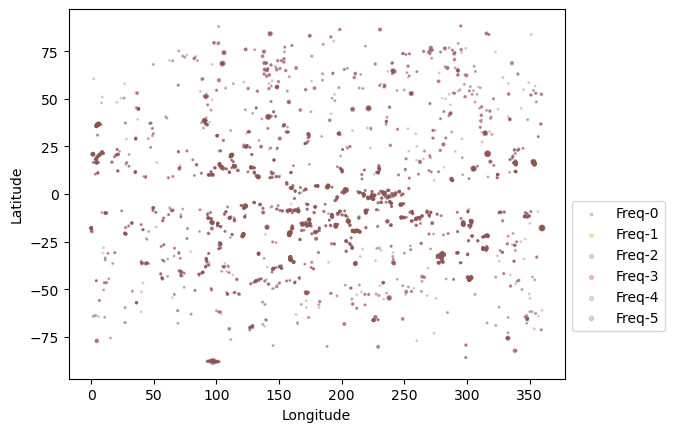

In [7]:
ssig = 10

for i in range(6):
    cat = point_cat[i]
    lat = cat.catalogue['lat'][cat.catalogue['q_opt']>ssig]
    lon = cat.catalogue['lon'][cat.catalogue['q_opt']>ssig]
    snr = cat.catalogue['q_opt'][cat.catalogue['q_opt']>ssig]

    plt.scatter(lon,lat,s=(snr/ssig)**1,alpha=0.25,label='Freq-%d'%i)#np.exp(psnr/5))
plt.xlabel(r'Longitude')
plt.ylabel(r'Latitude')
plt.legend(bbox_to_anchor=(1.,0.5),ncol=1);

In [8]:
# nside = 4096
# maskmap = np.ones(hp.nside2npix(nside))

# params_szifi['freqs'] = np.arange(6)
# data = szifi.input_data(params_szifi=params_szifi,params_data=params_data)

# for f in range(6):
    
#     theta_beam = data.data['experiment'].FWHM[f]/(2.*np.sqrt(2.*np.log(2)))*np.pi/180./60. # beam width in radians
#     print("Frequency %d, theta %.1f"%(f,theta_beam*60.*180./np.pi))
    
#     # Find healpix IDs of nearest pixels and mask them
#     lon, lat = hp.pix2ang(nside, hp.ang2pix(nside, point_cat[f].catalogue['lon'],point_cat[f].catalogue['lat'], lonlat=True), lonlat=True)
#     maskmap[hp.ang2pix(nside, lon, lat, lonlat=True)] = 0
    
#     # Find neighbors
#     neighbors = np.unique(hp.get_all_neighbours(nside, lon, lat, lonlat=True))
#     neighbors = neighbors[neighbors!=-1]
#     all_angs = hp.pix2ang(nside, neighbors,lonlat=True)

#     all_sin_lat = np.sin(all_angs[1]*np.pi/180.)
#     all_cos_lat = np.cos(all_angs[1]*np.pi/180.)
#     all_sin_lon = np.sin(all_angs[0]*np.pi/180.)
#     all_cos_lon = np.cos(all_angs[0]*np.pi/180.)

#     def dis_all(lon,lat):
#         sin_lat = np.sin(lat*np.pi/180.)[None,:]
#         cos_lat = np.cos(lat*np.pi/180.)[None,:]
#         sin_lon = np.sin(lon*np.pi/180.)[None,:]
#         cos_lon = np.cos(lon*np.pi/180.)[None,:]

#         return np.arccos(sin_lat*all_sin_lat[:,None]+cos_lat*all_cos_lat[:,None]*(cos_lon*all_cos_lon[:,None]+sin_lon*all_sin_lon[:,None]))

#     dis = dis_all(lon,lat)
#     close_points = np.min(dis,axis=1)<3*theta_beam

#     # Define neighboring pixels in mask
#     good_pix = neighbors[close_points]
    
#     print(len(good_pix))

#     old_ct = len(good_pix)
#     for _ in range(10):
#         neighbors = np.unique(hp.get_all_neighbours(nside, good_pix))
#         neighbors = neighbors[neighbors!=-1]

#         good_count = np.bincount(good_pix,minlength=hp.nside2npix(nside))
#         neigh_count = np.bincount(neighbors,minlength=hp.nside2npix(nside))
#         neighbors = np.where((neigh_count!=0)*(good_count==0))[0]
        
#         all_angs = hp.pix2ang(nside, neighbors,lonlat=True)

#         all_sin_lat = np.sin(all_angs[1]*np.pi/180.)
#         all_cos_lat = np.cos(all_angs[1]*np.pi/180.)
#         all_sin_lon = np.sin(all_angs[0]*np.pi/180.)
#         all_cos_lon = np.cos(all_angs[0]*np.pi/180.)

#         def dis_all(lon,lat):
#             sin_lat = np.sin(lat*np.pi/180.)[None,:]
#             cos_lat = np.cos(lat*np.pi/180.)[None,:]
#             sin_lon = np.sin(lon*np.pi/180.)[None,:]
#             cos_lon = np.cos(lon*np.pi/180.)[None,:]

#             return np.arccos(sin_lat*all_sin_lat[:,None]+cos_lat*all_cos_lat[:,None]*(cos_lon*all_cos_lon[:,None]+sin_lon*all_sin_lon[:,None]))

#         dis = dis_all(lon,lat)
#         close_points = np.min(dis,axis=1)<3*theta_beam

#         good_count[neighbors[close_points]] += 1
#         good_pix = np.where(good_count!=0)[0]
#         if old_ct == len(good_pix): break
#         old_ct = len(good_pix)
#         print(len(good_pix))

#     maskmap[good_pix] = 0
# print("Complete!")

# sim_dir = '/mnt/home/ophilcox/ceph/planck_pr4_freq/'
# hp.write_map(sim_dir+'%s/point_mask_snr10.fits'%str(sim_no+200).zfill(4),maskmap,overwrite=True)

## SZ Analysis

In [9]:
sim_no = 0
def load_sz_catalog():

    i = 0
    for batch in range(77):
        try:
            if i==0:
                tot_cat = np.load('outputs_v2/ffp10_%d_batch%d_arnaud.npy'%(sim_no,batch),allow_pickle=True).item()
                i += 1
            else:
                tot_cat.append(np.load('outputs_v2/ffp10_%d_batch%d_arnaud.npy'%(sim_no,batch),allow_pickle=True).item())
                i += 1
        except IOError:
            #print(batch)
            continue
    if i!=0:
        print("Found %d SZ clusters (SNR>4) from %d catalogues"%(len(tot_cat.catalogue['q_opt']),i))
    return tot_cat

# Cut to SNR of 5
snr_min = 4.5
sz_cat = szifi.get_catalogue_q_th(load_sz_catalog(), snr_min)
print("\nFound %d SZ clusters after SNR=%.1f cut"%(len(sz_cat.catalogue['q_opt']),snr_min))

Found 4804 SZ clusters (SNR>4) from 77 catalogues

Found 3075 SZ clusters after SNR=4.5 cut


In [10]:
sz_cat_merge = szifi.merge_detections(sz_cat,radius_arcmin=10,return_merge_flag=True,mode="fof")

print("\nFound %d SZ merged clusters"%len(sz_cat_merge.catalogue['q_opt']))


Found 1525 SZ merged clusters


### Check distance to point clusters

In [11]:
good_inds = []
for c in range(len(sz_cat_merge.catalogue['q_opt'])):
    clon = sz_cat_merge.catalogue['lon'][c]
    clat = sz_cat_merge.catalogue['lat'][c]
    
    bad = False
    for f in range(6):
        theta_beam = data.data['experiment'].FWHM[f]/(2.*np.sqrt(2.*np.log(2)))*np.pi/180./60. # beam width in radians

        cdis = hp.rotator.angdist((clon,clat),(point_cat[f].catalogue['lon'],point_cat[f].catalogue['lat']),lonlat=True)
        if np.min(cdis)<5*theta_beam: bad=True
        
    if not bad:
        good_inds.append(c)

sz_cat_nopoint = szifi.cat.get_catalogue_indices(sz_cat_merge, good_inds)
print("\nFound %d SZ clusters after point-source cut"%len(sz_cat_nopoint.catalogue['q_opt']))


Found 1493 SZ clusters after point-source cut


### Hotspot analysis

In [12]:
def load_png_catalog(sim_no, g=0.0):
    i = 0
    for batch in range(77):
        if g==0:
            name = 'outputs_v3/ffp10_%d_batch%d_soubhik.npy'%(sim_no,batch)
        else:
            name = 'outputs_v3/ffp10_%d_batch%d_soubhik_inj-g%.2f.npy'%(sim_no,batch,g)
        try:
            if i==0:
                tot_cat = np.load(name,allow_pickle=True).item()
                i += 1
            else:
                try:
                    tot_cat.append(np.load(name,allow_pickle=True).item())
                except KeyError:
                    pass
                    #print("Key: %s"%batch)
                i += 1
        except IOError:
            #print(batch)
            continue
    if i!=0:
        print("Found %d PNG g=%.2f hotspots (SNR>4) from %d catalogues"%(len(tot_cat.catalogue['q_opt']),g,i))
    return tot_cat

# Cut to SNR of 4
snr_min = 5
sim_no = 0
gs = [0,10,20,30,50]#[0,5,10,20,30,50,100]
png_gs = []
for g in gs:
    png_gs.append(szifi.get_catalogue_q_th(load_png_catalog(sim_no, g=g), snr_min))

Found 8584 PNG g=0.00 hotspots (SNR>4) from 77 catalogues
Found 8949 PNG g=10.00 hotspots (SNR>4) from 77 catalogues
Found 10089 PNG g=20.00 hotspots (SNR>4) from 77 catalogues
Found 10385 PNG g=30.00 hotspots (SNR>4) from 77 catalogues
Found 10882 PNG g=50.00 hotspots (SNR>4) from 77 catalogues


In [13]:
gal70 = hp.read_map('/mnt/home/ophilcox/ceph/planck_pr3_raw/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=3)

In [14]:
sz_mask = hp.read_map('COM_Mask_Compton-SZMap_2048_R2.00.fits')

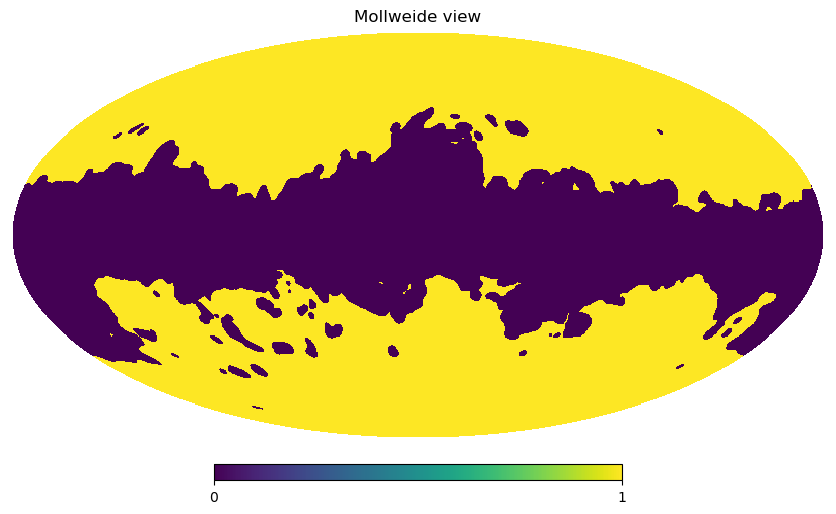

In [15]:
hp.mollview(sz_mask)

In [16]:
1-np.sum(sz_mask*1.)/len(sz_mask)

0.4226441979408264

In [17]:
def remove_point_sources(input_cat, exclusion_factor=5):
    good_inds = []
    for c in range(len(input_cat.catalogue['q_opt'])):
        clon = input_cat.catalogue['lon'][c]
        clat = input_cat.catalogue['lat'][c]

        bad = False
        for f in range(6):
            theta_beam = data.data['experiment'].FWHM[f]/(2.*np.sqrt(2.*np.log(2)))*np.pi/180./60. # beam width in radians

            cdis = hp.rotator.angdist((clon,clat),(point_cat[f].catalogue['lon'],point_cat[f].catalogue['lat']),lonlat=True)
            if np.min(cdis)<exclusion_factor*theta_beam: bad=True

        if not bad:
            good_inds.append(c)

    return szifi.cat.get_catalogue_indices(input_cat, good_inds)

def remove_cat(input_cat, removal_cat, dis_arcmin=10):
    good_inds = []
    for c in range(len(input_cat.catalogue['q_opt'])):
        clon = input_cat.catalogue['lon'][c]
        clat = input_cat.catalogue['lat'][c]

        cdis = hp.rotator.angdist((clon,clat),(removal_cat.catalogue['lon'],removal_cat.catalogue['lat']),lonlat=True)
        if not np.min(cdis)<dis_arcmin*np.pi/180./60.:
            good_inds.append(c)

    return szifi.cat.get_catalogue_indices(input_cat, good_inds)

def cut_on_map(input_cat, mask_map):
    return szifi.cat.get_catalogue_indices(input_cat, np.where(mask_map[hp.ang2pix(2048,input_cat.catalogue['lon'],input_cat.catalogue['lat'],lonlat=True)]))

def merge_cat(catalogue, size_factor=0.2,verb=True):
    
    len_pre = np.inf
    len_post = -1
    it = 0
    while len_pre!=len_post: 
        len_pre = len(catalogue.catalogue['q_opt'])
        catalogue = _merge_cat(catalogue, size_factor=size_factor, verb=verb)
        len_post = len(catalogue.catalogue['q_opt'])
        it +=1
    print('Finished in %d iterations'%it)
    return catalogue

def _merge_cat(catalogue,size_factor=0.2,verb=True):
    catalogue = szifi.cat.get_catalogue_indices(catalogue,np.where(catalogue.catalogue["q_opt"] != -1.)[0])
    n_clusters = len(catalogue.catalogue["q_opt"])
    catalogue_merged = szifi.cat.cluster_catalogue()
    catalogue_compare = catalogue

    i = 0

    indices_subtract = np.arange(len(catalogue_compare.catalogue["q_opt"]))
    merge_flags = np.zeros(0)

    while len(indices_subtract) > 0:

        catalogue_compare_new = szifi.cat.cluster_catalogue()

        for key in catalogue_compare.catalogue.keys():

            if len(catalogue_compare.catalogue[key]) > 0.:

                catalogue_compare_new.catalogue[key] = catalogue_compare.catalogue[key][indices_subtract]

        catalogue_compare = catalogue_compare_new

        n_clusters = len(catalogue_compare.catalogue["q_opt"])
        dist = szifi.sphere.get_angdist(catalogue_compare.catalogue["lon"][0]*np.ones(n_clusters),catalogue_compare.catalogue["lon"],
        catalogue_compare.catalogue["lat"][0]*np.ones(n_clusters),catalogue_compare.catalogue["lat"])
        
        dist_thresh = np.sqrt(4.*np.pi)*size_factor*(catalogue_compare.catalogue['eta_star'][0]+catalogue_compare.catalogue['eta_star'])/eta_0
        indices = np.where(dist <= dist_thresh)[0]
        merge_flags = np.append(merge_flags,len(indices))
        
        index_max = indices[np.argmax(catalogue_compare.catalogue["q_opt"][indices])]
        
        catalogue_new = szifi.cat.cluster_catalogue()

        for key in catalogue_compare.catalogue.keys():

            if len(catalogue_compare.catalogue[key]) > 0.:

                catalogue_new.catalogue[key] = np.array([catalogue_compare.catalogue[key][index_max]])

        catalogue_merged.append(catalogue_new,append_keys="new")
        
        indices_subtract = np.setdiff1d(np.arange(len(catalogue_compare.catalogue["q_opt"])),indices)
        
        i += 1

    if verb: print("Start size: %d, end size: %d"%(len(catalogue.catalogue['q_opt']),len(catalogue_merged.catalogue['q_opt'])))
    return catalogue_merged

def process_png(_png_cat, merge_radius=10, point_exclusion_factor=5, sz_radius=10):
    """Process a PNG catalogue, applying various cuts"""
    
    print("\nStarted with %d PNG hotspots"%len(_png_cat.catalogue['q_opt']))
    
    # Remove SZ mask
    png_cat = cut_on_map(_png_cat, sz_mask)
    print("Found %d PNG hotspots after SZ mask cut"%len(png_cat.catalogue['q_opt']))
    
    # Remove galactic plane
    #png_cat = cut_on_map(png_cat, gal70)
    #print("Found %d PNG hotspots after 70%% galactic plane cut"%len(png_cat.catalogue['q_opt']))
    
    # Remove nearby point-sources
    png_cat = remove_point_sources(png_cat, exclusion_factor=point_exclusion_factor)
    print("Found %d PNG hotspots after point-source cut"%len(png_cat.catalogue['q_opt']))

    # Remove SZ sources
    png_cat = remove_cat(png_cat, sz_cat_nopoint, dis_arcmin=sz_radius)
    print("Found %d PNG hotspots after SZ-source cut"%len(png_cat.catalogue['q_opt']))
    
    # Merge sources
    # png_cat = szifi.merge_detections(png_cat,radius_arcmin=merge_radius,return_merge_flag=False,mode="closest")
    # #png_cat = merge_cat(png_cat,0.2,False)
    # print("Found %d merged PNG hotspots"%len(png_cat.catalogue['q_opt']))
    
    # Return
    return png_cat

png_g_procs = [process_png(png_g, merge_radius=10, point_exclusion_factor=5, sz_radius=10) for png_g in png_gs]


Started with 3077 PNG hotspots
Found 803 PNG hotspots after SZ mask cut
Found 803 PNG hotspots after point-source cut
Found 689 PNG hotspots after SZ-source cut

Started with 2971 PNG hotspots
Found 754 PNG hotspots after SZ mask cut
Found 754 PNG hotspots after point-source cut
Found 754 PNG hotspots after SZ-source cut

Started with 4191 PNG hotspots
Found 1209 PNG hotspots after SZ mask cut
Found 1209 PNG hotspots after point-source cut
Found 1208 PNG hotspots after SZ-source cut

Started with 4603 PNG hotspots
Found 1423 PNG hotspots after SZ mask cut
Found 1423 PNG hotspots after point-source cut
Found 1422 PNG hotspots after SZ-source cut

Started with 5078 PNG hotspots
Found 1659 PNG hotspots after SZ mask cut
Found 1659 PNG hotspots after point-source cut
Found 1657 PNG hotspots after SZ-source cut


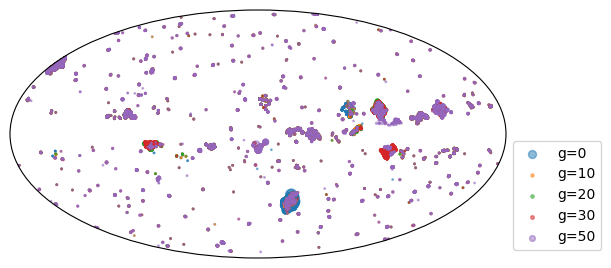

In [18]:
def plot_cat(cat, ssig,label,size=1, alpha=1):
    lat = cat.catalogue['lat'][cat.catalogue['q_opt']>ssig]
    lon = cat.catalogue['lon'][cat.catalogue['q_opt']>ssig]
    snr = cat.catalogue['q_opt'][cat.catalogue['q_opt']>ssig]
    ax.scatter(np.radians(lon-180),np.radians(lat),s=5*size*(snr/ssig)**1,alpha=alpha,label=label)

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

snr_min = 5

for gi,g in enumerate(gs):
    plot_cat(png_gs[gi], snr_min, 'g=%d'%g, alpha=0.5,size=0.2)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([]);
ax.legend(bbox_to_anchor=(1.,0.5),ncol=1);

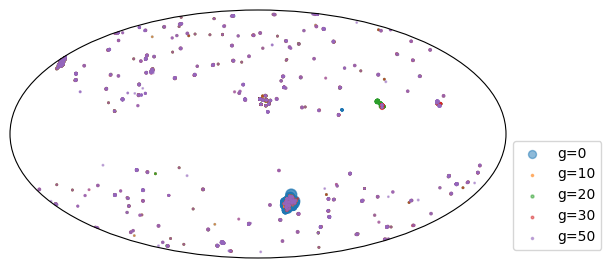

In [19]:
def plot_cat(cat, ssig,label,size=1, alpha=1):
    lat = cat.catalogue['lat'][cat.catalogue['q_opt']>ssig]
    lon = cat.catalogue['lon'][cat.catalogue['q_opt']>ssig]
    snr = cat.catalogue['q_opt'][cat.catalogue['q_opt']>ssig]
    ax.scatter(np.radians(lon-180),np.radians(lat),s=5*size*(snr/ssig)**1,alpha=alpha,label=label)

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

snr_min = 5

for gi,g in enumerate(gs):
    plot_cat(png_g_procs[gi], snr_min, 'g=%d'%g, alpha=0.5,size=0.2)
    
#ax.scatter(np.radians(pgcc['GLON'][pgcc['SNR']>10]-180.),np.radians(pgcc['GLAT'][pgcc['SNR']>10]),alpha=0.5,s=1)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([]);
ax.legend(bbox_to_anchor=(1.,0.5),ncol=1);

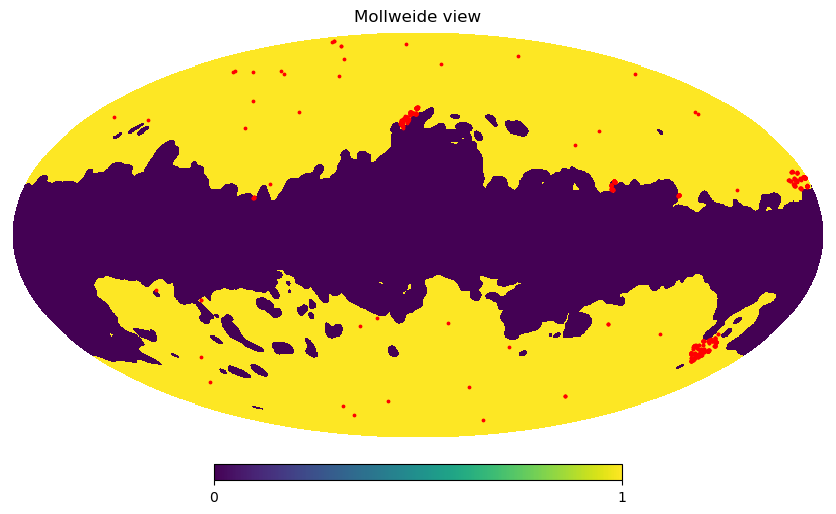

In [20]:
hp.mollview(sz_mask)
ss = 5
gi = 0
hp.projscatter(png_g_procs[gi].catalogue['lon'][png_g_procs[gi].catalogue['q_opt']>ss],png_g_procs[gi].catalogue['lat'][png_g_procs[gi].catalogue['q_opt']>ss],s=3,lonlat=True,c='r')
#hp.projscatter(nt_official['lon'],nt_official['lat'],s=3,lonlat=True)

In [21]:
true_cat = np.load('injection300_v2_sim%d.npz'%sim_no)
all_eta_star = np.geomspace(10,1000,10)

def identify_true_sources(input_cat, dis_arcmin=10):#, size_factor=0.05):
    
    lon = input_cat.catalogue['lon']
    lat = input_cat.catalogue['lat']

    match_sources = []
    all_close = []
    for t in range(len(true_cat['lon'])):
        
        tdis = hp.rotator.angdist((true_cat['lon'][t],true_cat['lat'][t]),(lon,lat),lonlat=True)
        
        dist_thresh = dis_arcmin*np.pi/180./60. #np.sqrt(4.*np.pi)*size_factor*(true_cat['eta_stars'][t]+input_cat.catalogue['eta_star'])/eta_0
        close_ids = np.where(tdis<dist_thresh)[0]
        
        if len(close_ids)==0:
            match_sources.append([np.nan,np.nan,np.nan,np.nan,0,np.nan])
        else:
            indmax = np.argmax(input_cat.catalogue['q_opt'][close_ids])
            match_sources.append([input_cat.catalogue['lon'][close_ids][indmax],#.mean(),
                                  input_cat.catalogue['lat'][close_ids][indmax],#.mean(),
                                  input_cat.catalogue['q_opt'][close_ids][indmax],#.max(),
                                  input_cat.catalogue['eta_star'][close_ids][indmax],#.mean(),
                                  len(close_ids),
                                  input_cat.catalogue['y0'][close_ids][indmax],#.max()
                                 ])
        all_close.append(close_ids)
            
    return np.asarray(match_sources), np.unique(np.concatenate(all_close))

g_matchs = [identify_true_sources(png_g_proc) for png_g_proc in png_g_procs]

In [22]:
#compsep_map = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')

true_disc = sz_mask[hp.ang2pix(2048,true_cat['lon'],true_cat['lat'],lonlat=True)]
true_good = np.where(true_disc)[0]

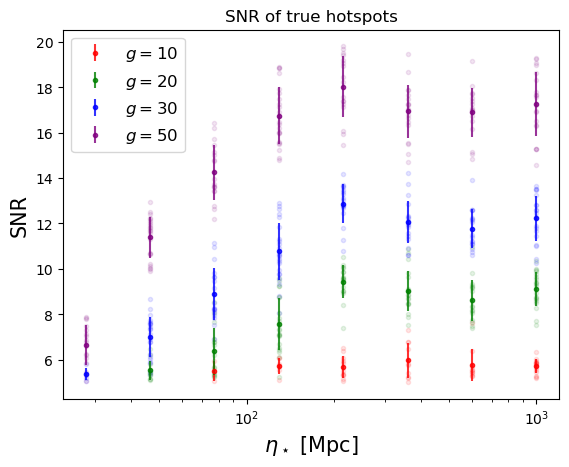

In [23]:
cs = ['','r','g','b','purple','orange','teal']
for gi,g in enumerate(gs):
    if g==0: continue
    
    means = []
    errs = []
    for eta_star in all_eta_star:
        f = np.where(true_cat['eta_stars']==eta_star)[0]
        all_stars = g_matchs[gi][0][f][:,2]
        means.append(all_stars[np.isfinite(all_stars)].mean())
        errs.append(all_stars[np.isfinite(all_stars)].std())
    plt.errorbar(all_eta_star,means,yerr=errs,ls='',marker='.',alpha=0.8,label=r'$g=%d$'%g,c=cs[gi])
   
plt.title("SNR of true hotspots")
for gi,g in enumerate(gs):
    if g==0: continue
    plt.scatter(true_cat['eta_stars'],g_matchs[gi][0][:,2],marker='.',alpha=0.1,c=cs[gi])
plt.xlabel(r'$\eta_\star$ [$\mathrm{Mpc}$]',fontsize=15);
plt.ylabel(r'SNR',fontsize=15);
plt.xscale('log');
plt.legend(fontsize=12);

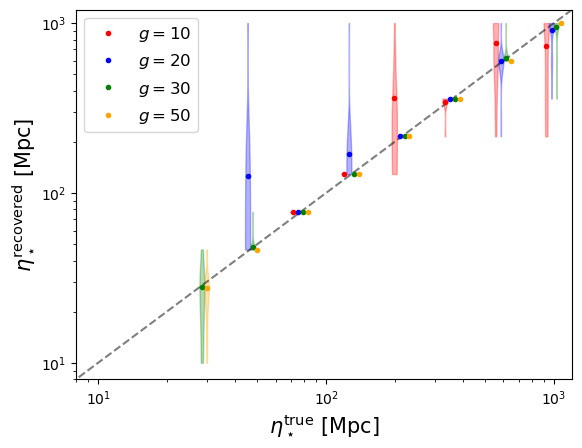

In [24]:
cs = ['k','r','b','g','orange']
#plt.title("Sizes of true hotspots")
for gi,g in enumerate(gs):
    if g==0: continue
    if g<5: continue
    dat = []
    tes = []
    for eta_star in all_eta_star:
        f = np.where(true_cat['eta_stars']==eta_star)[0]
        all_stars = g_matchs[gi][0][f][:,3]
        if np.sum(np.isfinite(all_stars))>0:
            dat.append(all_stars[np.isfinite(all_stars)])
            tes.append(eta_star)
    vp = plt.violinplot(dat, np.asarray(tes)*(1+(gi-2.5)/20.), widths=0.05*np.asarray(tes),showmeans=False,showextrema=False)
    plt.errorbar(np.asarray(tes)*(1+(gi-2.5)/20.), [np.mean(d) for d in dat], ls='',c=cs[gi],marker='.',label=r'$g=%d$'%g)#yerr=[np.std(d) for d in dat],l
    for pc in vp['bodies']:
        pc.set_color(cs[gi])
        pc.set_edgecolor(cs[gi])
        pc.set_alpha(0.3)
    
plt.xlabel(r'$\eta_\star^{\rm true}$ [$\mathrm{Mpc}$]',fontsize=15);
plt.ylabel(r'$\eta_\star^{\rm recovered}$ [$\mathrm{Mpc}$]',fontsize=15);
plt.xscale('log');
plt.xlim(8,1200);
plt.ylim(8,1200);
plt.legend(fontsize=12);
plt.yscale('log')
plt.plot(np.arange(1,10000),np.arange(1,10000),ls='--',alpha=0.5,c='k')
plt.savefig('pub_plots/eta_test1.pdf',bbox_inches='tight')

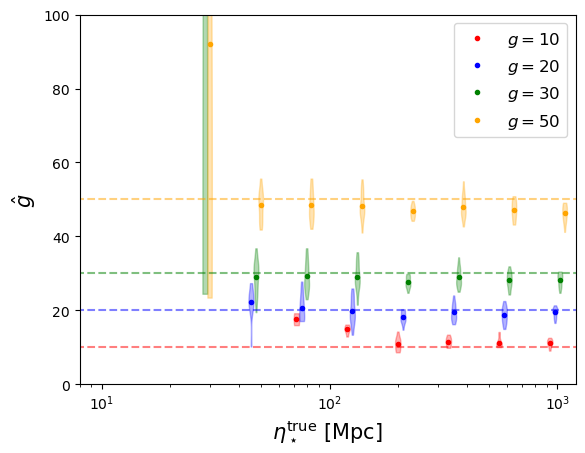

In [25]:
cs = ['k','r','b','g','orange']
for gi,g in enumerate(gs):
    if g==0: continue
    if g<5: continue
    dat = []
    tes = []
    for eta_star in all_eta_star:
        f = np.where(true_cat['eta_stars']==eta_star)[0]
        all_g = g_matchs[gi][0][f][:,5]
        if np.sum(np.isfinite(all_g))>0:
            dat.append(all_g[np.isfinite(all_g)])
            tes.append(eta_star)
    vp = plt.violinplot(dat, np.asarray(tes)*(1+(gi-2.5)/20.), widths=0.05*np.asarray(tes),showmeans=False,showextrema=False)
    plt.errorbar(np.asarray(tes)*(1+(gi-2.5)/20.), [np.mean(d) for d in dat], ls='',c=cs[gi],marker='.',label=r'$g=%d$'%g)
    for pc in vp['bodies']:
        pc.set_color(cs[gi])
        pc.set_edgecolor(cs[gi])
        pc.set_alpha(0.3)
    plt.hlines(g,0,1200,color=cs[gi],linestyles='--',alpha=0.5)
plt.xlabel(r'$\eta_\star^{\rm true}$ [$\mathrm{Mpc}$]',fontsize=15);
plt.ylabel(r'$\hat{g}$',fontsize=15);
plt.xscale('log');
plt.xlim(8,1200);
plt.ylim(0,100);
#plt.ylim(20,1200);
plt.legend(fontsize=12);
plt.savefig('pub_plots/g_test1.pdf',bbox_inches='tight')

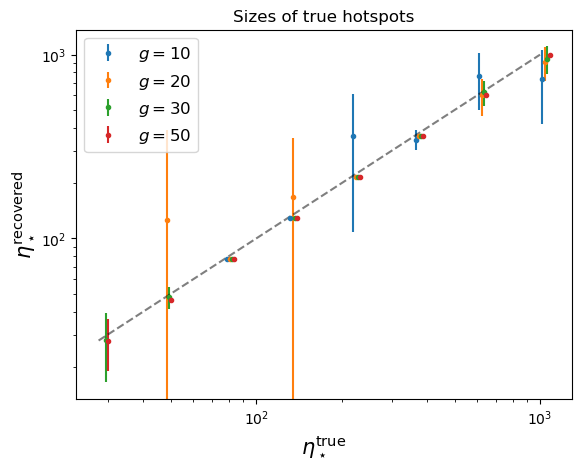

In [26]:
plt.title("Sizes of true hotspots")

for gi,g in enumerate(gs):
    if g<=5: continue
    if g>50: continue
    if g==0: continue
    
    means = []
    errs = []
    for eta_star in all_eta_star:
        f = np.where(true_cat['eta_stars']==eta_star)[0]
        all_stars = g_matchs[gi][0][f][:,3]
        means.append(all_stars[np.isfinite(all_stars)].mean())
        errs.append((all_stars[np.isfinite(all_stars)].std()))
    plt.errorbar(all_eta_star*(1+gi/50.),means,yerr=errs,ls='',marker='.',alpha=1,label=r'$g=%d$'%g)
plt.xlabel(r'$\eta_\star^{\rm true}$',fontsize=15);
plt.ylabel(r'$\eta_\star^{\rm recovered}$',fontsize=15);
plt.xscale('log');
plt.legend(fontsize=12);
plt.yscale('log')
plt.plot(all_eta_star[2:],all_eta_star[2:],ls='--',alpha=0.5,c='k')

In [27]:
true_cat['eta_stars'][true_good].shape[0]/300.

0.6166666666666667

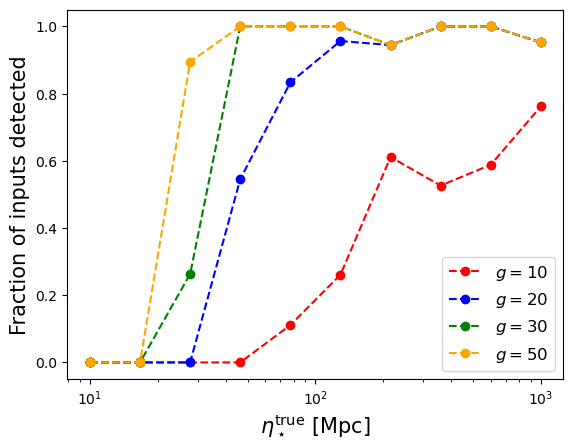

In [54]:
completeness = []
for gi,g in enumerate(gs):
    comp = []
    if g!=0:
        for eta_star in all_eta_star:
            f = np.where(true_cat['eta_stars']==eta_star)[0]
            comp.append(np.isfinite(g_matchs[gi][0][f,0]).sum()/np.sum(true_cat['eta_stars'][true_good]==eta_star))            
    completeness.append(comp)

for gi, g in enumerate(gs):
    
    if g==0: continue
    
    plt.plot(all_eta_star,completeness[gi],marker='o',ls='--',c=cs[gi],alpha=1.,label=r'$g=%d$'%g)
    
plt.xlabel(r'$\eta_\star^{\rm true}$ [Mpc]',fontsize=15);
plt.ylabel(r'Fraction of inputs detected',fontsize=15);
plt.legend(fontsize=12);
plt.xscale('log');
#plt.savefig('pub_plots/comp_test1.pdf',bbox_inches='tight')

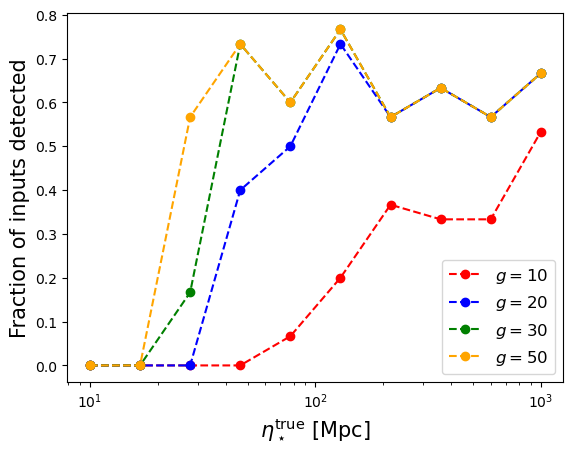

In [28]:
completeness = []
for gi,g in enumerate(gs):
    comp = []
    if g!=0:
        for eta_star in all_eta_star:
            f = np.where(true_cat['eta_stars']==eta_star)[0]
            comp.append(np.isfinite(g_matchs[gi][0][f,0]).sum()/len(f))            
    completeness.append(comp)

for gi, g in enumerate(gs):
    
    if g==0: continue
    
    plt.plot(all_eta_star,completeness[gi],marker='o',ls='--',c=cs[gi],alpha=1.,label=r'$g=%d$'%g)
    
plt.xlabel(r'$\eta_\star^{\rm true}$ [Mpc]',fontsize=15);
plt.ylabel(r'Fraction of inputs detected',fontsize=15);
plt.legend(fontsize=12);
plt.xscale('log');
plt.savefig('pub_plots/comp_test1.pdf',bbox_inches='tight')

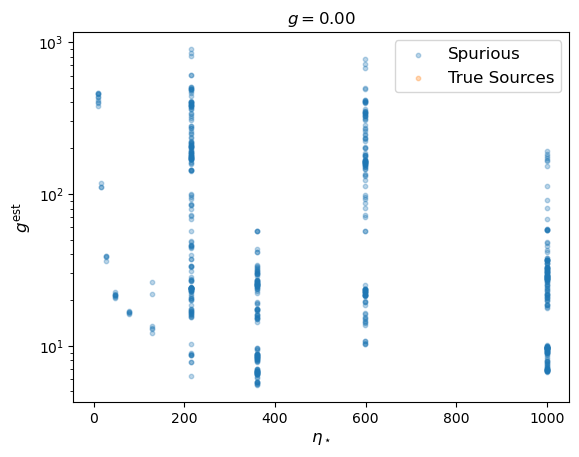

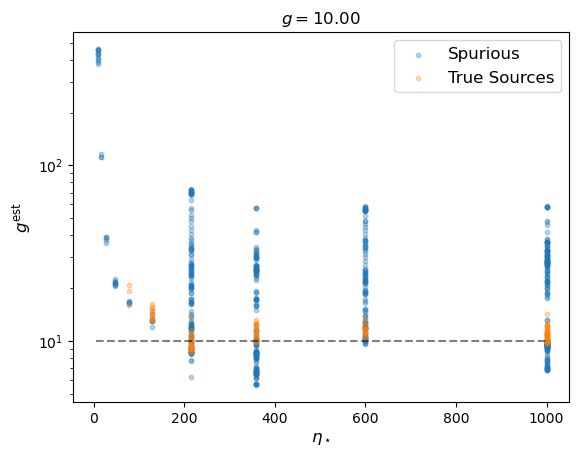

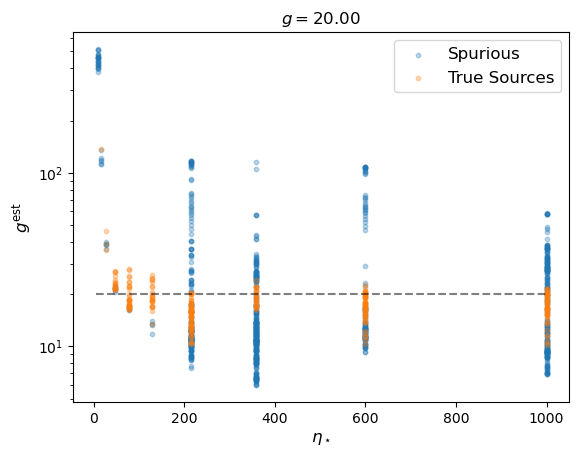

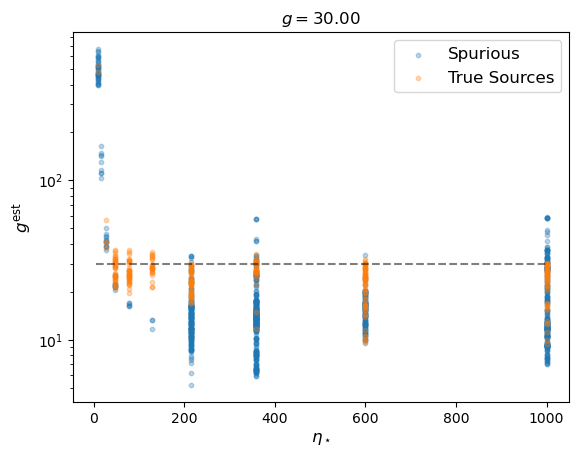

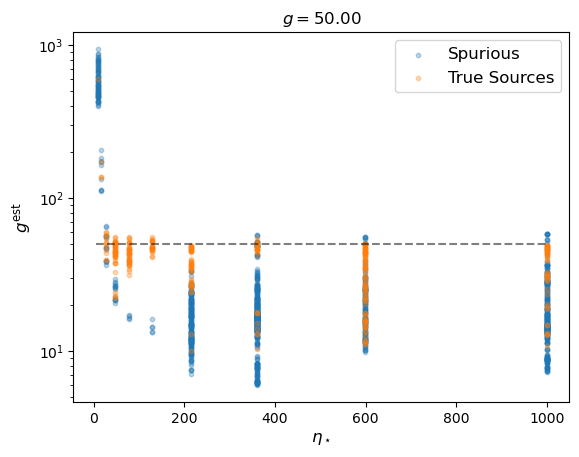

In [161]:
for gi,g in enumerate(gs):
    in_catalog = np.asarray([i in g_matchs[gi][1] for i in range(len(png_g_procs[gi].catalogue['y0']))])

    plt.figure()
    plt.title(r'$g=%.2f$'%g,fontsize=12);
    plt.scatter(png_g_procs[gi].catalogue['eta_star'][~in_catalog],png_g_procs[gi].catalogue['y0'][~in_catalog],alpha=0.3,s=10,label='Spurious')
    plt.scatter(png_g_procs[gi].catalogue['eta_star'][in_catalog],png_g_procs[gi].catalogue['y0'][in_catalog],alpha=0.3,s=10,label='True Sources')
    plt.hlines(g,5,1000,linestyles='--',color='k',alpha=0.5)
    plt.yscale('log');
    plt.legend(fontsize=12);
    plt.xlabel(r'$\eta_\star$',fontsize=12);
    plt.ylabel(r'$g^{\rm est}$',fontsize=12);

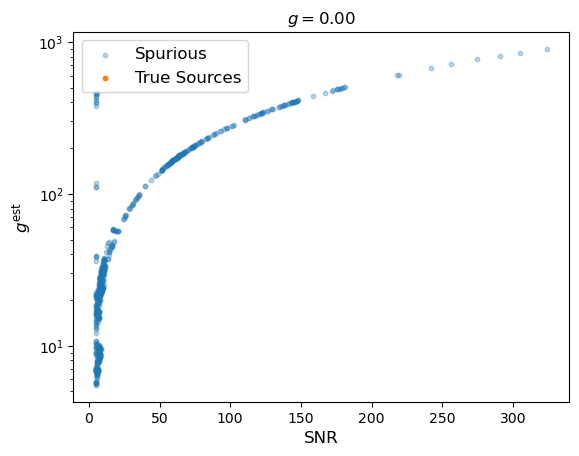

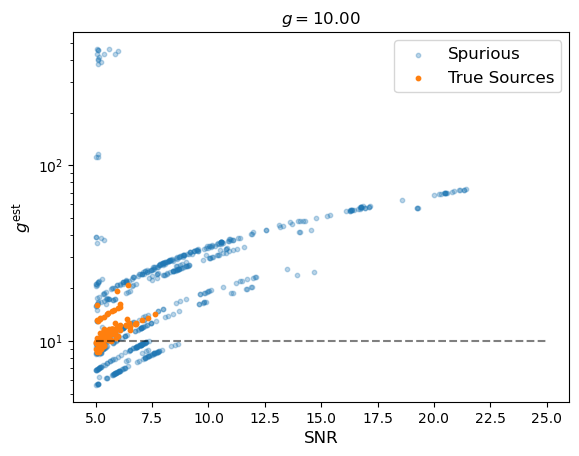

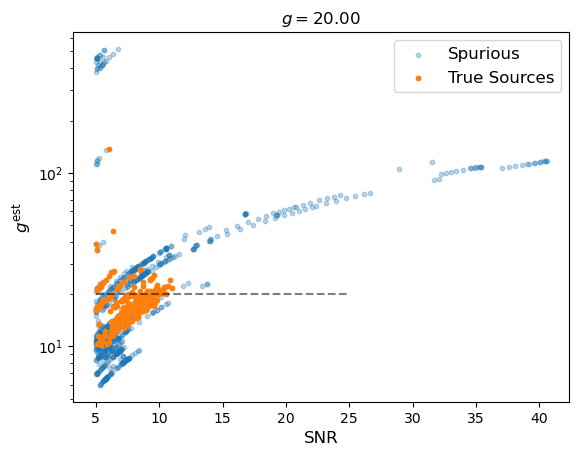

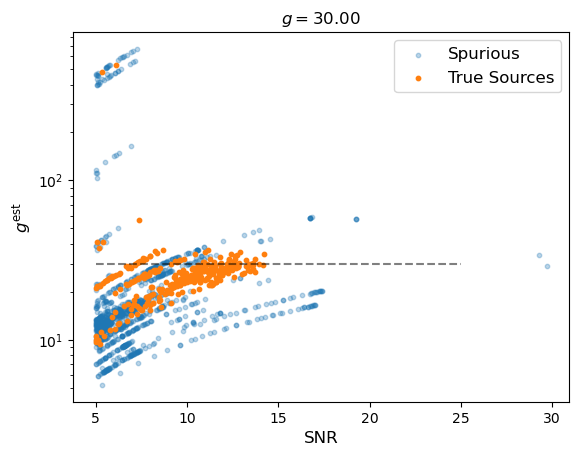

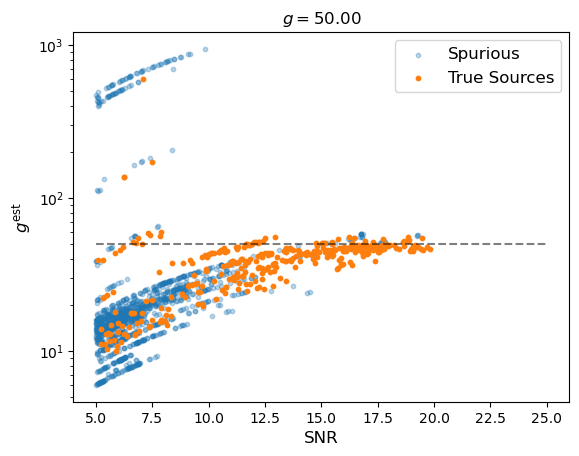

In [162]:
for gi,g in enumerate(gs):
    in_catalog = np.asarray([i in g_matchs[gi][1] for i in range(len(png_g_procs[gi].catalogue['y0']))])

    plt.figure()
    plt.title(r'$g=%.2f$'%g,fontsize=12);
    plt.scatter(png_g_procs[gi].catalogue['q_opt'][~in_catalog],png_g_procs[gi].catalogue['y0'][~in_catalog],alpha=0.3,s=10,label='Spurious')
    plt.scatter(png_g_procs[gi].catalogue['q_opt'][in_catalog],png_g_procs[gi].catalogue['y0'][in_catalog],alpha=1.0,s=10,label='True Sources')
    plt.hlines(g,5,25,linestyles='--',color='k',alpha=0.5)
    plt.yscale('log');
    plt.legend(fontsize=12);
    plt.xlabel(r'SNR',fontsize=12);
    plt.ylabel(r'$g^{\rm est}$',fontsize=12);

### Error distribution

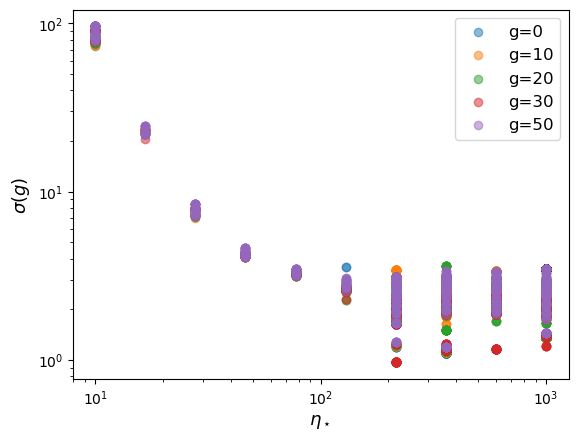

In [163]:
for gi,g in enumerate(gs):
    plt.scatter(png_g_procs[gi].catalogue['eta_star'],png_g_procs[gi].catalogue['y0']/png_g_procs[gi].catalogue['q_opt'],alpha=0.5,label=r'g=%d'%g)
plt.xlabel(r'$\eta_\star$',fontsize=13);
plt.ylabel(r'$\sigma(g)$',fontsize=13);
plt.legend(fontsize=12);
plt.yscale('log')
plt.xscale('log')

(8.0, 1200.0)

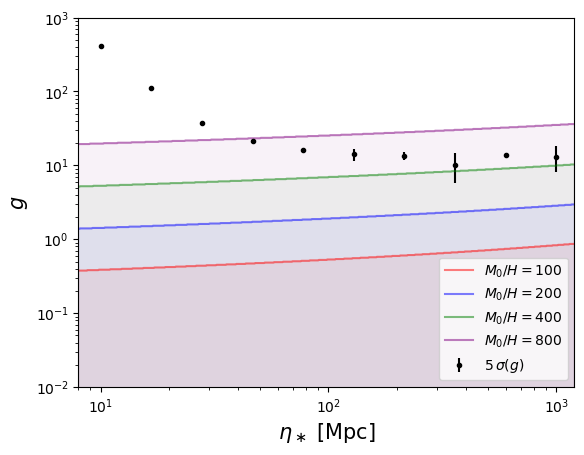

In [164]:
Delta_eta_s = 19
N_spots = lambda g, eta_star, M0_by_H: 4e8*g**(3./2.)*(Delta_eta_s/100.)*(100./eta_star)**3*np.exp(-np.pi*(M0_by_H**2-2.)/58.9**2/g)

peta_star = png_g_procs[0].catalogue['eta_star']
psig_g = png_g_procs[0].catalogue['y0']/png_g_procs[0].catalogue['q_opt']
sigs = []
errs = []
for eta_star in all_eta_star:
    f = np.where(peta_star==eta_star)[0]
    sigs.append(psig_g[f].mean())
    errs.append(psig_g[f].std())
plt.errorbar(all_eta_star, 5*np.asarray(sigs), yerr=5*np.asarray(errs), alpha=1, label=r'$5\,\sigma(g)$', ls='',marker='.', c='k')

g_needed = []
gvs = [100,200,400,800]
eta_star_all = np.geomspace(min(peta_star)*0.8,max(peta_star)*1.2,1000)
for i in range(len(eta_star_all)):
    g_all = np.geomspace(1e-3,1000,1000)
    g_needed.append([g_all[np.where(N_spots(g_all, eta_star_all[i], gv)>1)[0][0]] for gv in gvs])

cs = ['r','b','g','purple']
for i in range(4):
    plt.fill_between(eta_star_all,0.*eta_star_all,np.asarray(g_needed)[:,i],alpha=0.05,color=cs[i])
    plt.plot(eta_star_all,np.asarray(g_needed)[:,i],label=r'$M_0/H=%d$'%(gvs[i]),alpha=0.5,c=cs[i])
plt.ylim(0.01,1000);
plt.yscale('log')
plt.xscale('log')
plt.legend();
plt.xlabel(r'$\eta_\ast$ [Mpc]',fontsize=15);
plt.ylabel(r'$g$',fontsize=15);
plt.xlim(min(eta_star_all),max(eta_star_all))

## Notes:

#### General procedure
- First find all point sources with SNR > 10 in each of the 6 frequency channels. This uses only a galactic mask.
- Create point-source mask, removing any pixels within $3\sigma_{\rm beam}$ of the point sources (for each channel), via a recursive search, using an $N_{\rm side}=4096$ map.
- **TODO**: Check if there's any other holes in the mask! 
- Find the tSZ clusters with 15 values of $\theta_{500}\in[0.5,50]$ arcmin, merging at $10'$ (following 2204.13780, based on 1502.01598), and using an SNR threshold of 5. We fix $\ell\in[100,2500]$ and use one level of recursion to optimize the SNR.
- Reject tSZ if within $5\sigma_{\rm beam}(f)$ of a point-sources at frequency $f$.
- Find the PNG hotspots with 10 values of $\eta_\star$ in $[5,500]$ at fixed $\eta_{\rm HS}=\eta_{\rm rec}$, for SNR of 5, and merging at $10'$. We fix $\ell\in[100,2500]$ and do not use recursion (since the null hypothesis has no clusters).
- Reject the hotspots if (a) within $5\sigma_{\rm beam}(f)$ of a point-sources at frequency $f$, (b) within $10'$ of an SZ cluster, (c) outside the Planck GAL070 map (i.e. in the most dusty 30\%).

#### Testing
- Create a fake map containing $30$ clusters at each of $10$ values of $\eta_\star$, separated by at least $1^\circ$ in the sky.
- Add this to a single FFP10 simulation. 
- Analyze with the above pipeline, testing (a) the recovered values of $g$ and $\eta_\star$, (b) the SNR as a function of $\eta_\star$, (c) the completeness, i.e. the fraction of injected clusters recovered by the pipeline.

#### Some Conclusions
- From the noise distribution, $\sigma(g)>1$ for $\eta_\star\lesssim 20$ Mpc. This is a lower limit on $\eta_\star$ (partly caused by point-source confusion).
- Sources are likely detectable also for $\eta_\star>500$ Mpc, though one must ensure the template is not larger than $7^\circ$ (the projection size).
- For $\eta_\star\gtrsim 50$, $g=1$ clusters are detectable, with a maximum completeness of $\approx 70\%$ (mostly from the mask).
- $\ell_{\rm min}=100$ might be too conservative in practice, and limits the detectability of large templates.
- $g=3$ is too large in this test; it causes significant back-reaction onto the other detections
- **TODO**: Careful of normalization of high-frequency maps!!!
- **TODO**: repeat for component-separated map!
- **TODO**: Add PGCC cold gas clouds??
